In [2]:
import numpy as np
import os

def save_data(*arrays, folder="saved_data"):
    os.makedirs(folder, exist_ok=True)  # Create the folder if it doesn't exist
    filenames = [
        "train_set_branch_y.npy", "train_set_branch_t.npy", "train_set_trunk.npy",
        "branch_mask.npy", "test_truth.npy","samples.npy","samples_noisy.npy"
    ]
    for array, filename in zip(arrays, filenames):
        np.save(os.path.join(folder, filename), array)
    print("Data saved successfully.")

def load_data(folder="saved_data"):
    filenames = [
        "train_set_branch_y.npy", "train_set_branch_t.npy", "train_set_trunk.npy",
        "branch_mask.npy", "test_truth.npy","samples.npy","samples_noisy.npy"

    ]
    arrays = [np.load(os.path.join(folder, filename), allow_pickle=True) for filename in filenames]
    print("Data loaded successfully.")
    return arrays
grid_size = 128
temporal_size = 20

In [3]:
import random
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import beta as beta_dist  # Import with a different name
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_data(grid_size):
    # Parameters
    num_functions =100000   # Total number of functions to generate
    batch_size = 1000         # Batch size for processing
    n_batches = num_functions // batch_size
    
    # Gaussian parameters for noise std
    def rademacher_mask(n):
        rademacher_values = np.random.choice([-1, 1], size=n)    
        mask = (rademacher_values + 1) // 2  # This will map -1 to 0 and +1 to 1
        return mask

    def rbf_kernel_matrix(X, length_scale=1.0, variance=1.0):
        """
        Compute the RBF kernel matrix for input array X.
        """
        # Compute pairwise squared distances
        X = X.reshape(-1, 1)
        sqdist = np.sum(X**2, axis=1).reshape(-1, 1) + \
                np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
        K = variance * np.exp(-0.5 * sqdist / length_scale**2)
        return K

    variance = 1.0           # Variance parameter σ²
    min = 40
    max = 80
    # Create input grid
    X = np.linspace(0, 1, grid_size)  # Points in [0, 1]


    train_set_branch_y_collection = []
    train_set_branch_t_collection = []

    train_set_trunk_collection = []
    branch_mask_collection = []
    trunk_mask_collection = []
    test_truth_collection = []

    samples_ = []
    samples_noisy_ = []

    for i in range(num_functions):
        alpha, beta_param = np.random.choice([1.0,2.0,5.0], 1,replace=False)[0],np.random.choice([1.0,2.0,5.0], 1,replace=False)[0]

        if i % 1000 == 0:
            print(i)
        l = beta_dist.rvs(alpha, beta_param)

        K = rbf_kernel_matrix(X, length_scale=l, variance=variance)

        mean = np.zeros(grid_size)
        noise_std = np.abs(np.random.normal(0, 0.1))

        samples = np.random.multivariate_normal(mean, K, size=1).reshape(-1)
        samples_noisy = samples + np.random.normal(0, noise_std, size=grid_size)

        samples = (samples - samples.mean()) / samples.std() #z-scoring
        samples_noisy = (samples_noisy - samples_noisy.mean()) / samples_noisy.std() #z-scoring

     
        train_set_trunk = X.copy()

        r = random.randint(min, max)
        if i < num_functions/2: 
            indices = (np.random.choice(np.arange(0, grid_size), r, replace=False))
        else:
            indices = np.arange(0, grid_size)[::random.randint(2, 4)]

        
        train_set_branch_y = np.append(samples_noisy[indices],np.zeros(grid_size - len(indices)))
        train_set_branch_t = np.append(X[indices],np.zeros(grid_size - len(indices)))

        branch_mask = np.append(np.ones(len(indices)), np.zeros(grid_size - len(indices)))    

     

        test_truth = samples.copy()


        train_set_branch_y_collection.append(train_set_branch_y)
        train_set_branch_t_collection.append(train_set_branch_t)
        train_set_trunk_collection.append(train_set_trunk)
        branch_mask_collection.append(branch_mask)
        test_truth_collection.append(test_truth)
        samples_.append(samples)
        samples_noisy_.append(samples_noisy)
    return (train_set_branch_y_collection,train_set_branch_t_collection, train_set_trunk_collection, branch_mask_collection, test_truth_collection,samples_,samples_noisy_)


In [80]:

data = prepare_data(grid_size)
save_data(*data)




0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
Data saved successfully.


In [4]:
(train_set_branch_y, train_set_branch_t, train_set_trunk,
 branch_mask, test_truth,samples,samples_noisy) = load_data()

Data loaded successfully.


In [5]:


import torch
import torch.nn as nn

class DeepONet(torch.nn.Module):

    def __init__(self, indicator_dim, d_model, heads=1, p=128):
        super(DeepONet, self).__init__()
        self.p = p
        self.branch_embedding_y = nn.Linear(1, d_model)
        self.branch_embedding_t = nn.Linear(1, d_model)
        self.trunk_embedding_t = nn.Linear(1, d_model)
        
        self.embedding_act = nn.Sequential(nn.LayerNorm(d_model),nn.LeakyReLU())
        self.branch_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, batch_first=True), num_layers=6, enable_nested_tensor=False)

        self.branch_mlp = nn.Sequential(nn.Linear(indicator_dim*d_model,d_model),nn.LeakyReLU(),
                                        nn.Linear(d_model, self.p),nn.LeakyReLU())  
        
        self.trunk_mlp =   nn.Sequential(nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(d_model),
                                         nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.Linear(d_model, d_model),nn.LeakyReLU(),
                                         nn.LayerNorm(d_model),
                                         nn.Linear(d_model, self.p),nn.LeakyReLU())  
        
      

     #   self.trunk_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, batch_first=True), num_layers=4, enable_nested_tensor=False)
  
    def forward(self, y, t, t_sample, y_mask):
        y = y.unsqueeze(-1) * y_mask.unsqueeze(-1)
        t = t.unsqueeze(-1) * y_mask.unsqueeze(-1)
        t_sample = t_sample.unsqueeze(-1)
        branch_embedding_y = self.branch_embedding_y(y)
        branch_embedding_t = self.branch_embedding_t(t)
        trunk_encoder_input = self.trunk_embedding_t(t_sample)

       
        y_mask_enc = torch.where(y_mask == 1, False, True)
      #  t_sample_mask_enc = torch.where(t_sample_mask == 1, False, True)


        branch_encoder_input = self.embedding_act(branch_embedding_y + branch_embedding_t)
        branch_encoder_output = self.branch_encoder(branch_encoder_input, src_key_padding_mask=y_mask_enc)
        #trunk_encoder_output = self.trunk_encoder(trunk_encoder_input, src_key_padding_mask=t_sample_mask_enc)

        branch_encoder_output = branch_encoder_output * y_mask.unsqueeze(-1)
        print(branch_encoder_output.shape)
       # trunk_encoder_output = trunk_encoder_output * t_sample_mask.unsqueeze(-1)

        branch_encoder_output = (branch_encoder_output).view(branch_encoder_output.shape[0],-1)

        branch_output = self.branch_mlp(branch_encoder_output) 
        trunk_output = self.trunk_mlp(trunk_encoder_input  ) 

        combined = torch.bmm(branch_output.unsqueeze(1), trunk_output.transpose(1, 2)).squeeze()
        return combined

In [74]:

import torch.nn.utils as nn_utils
import math
from dataset import TimeSeriesDataset

class InverseSquareRootLR(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, init_lr, min_lr=1e-9, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.init_lr = init_lr
        self.min_lr = min_lr
        super(InverseSquareRootLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        if step < self.warmup_steps:
            # Linear warmup
            lr = self.init_lr * (step / self.warmup_steps)
        else:
            # Inverse square root decay
            lr = self.init_lr * math.sqrt(self.warmup_steps / step)

        # Ensure learning rate doesn't go below minimum
        lr = max(lr, self.min_lr)

        return [lr for _ in self.base_lrs]
    

dataset = TimeSeriesDataset(
    train_set_branch_y,
    train_set_branch_t,
    train_set_trunk,
    branch_mask,
    test_truth
)
epochs = 20
# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
model = DeepONet(grid_size,d_model=256,heads=2,p=164)

model.to(device)
model.train()

print(f"Params: {sum(p.numel() for p in model.parameters())}")
optim = torch.optim.AdamW(model.parameters(),lr=0.0001)
lr_scheduler = InverseSquareRootLR(optim,warmup_steps=200,init_lr=0.0001,min_lr=0.000005)

loss = 0
for epoch in range(epochs):
    for batch in dataloader:
        train_set_branch_y = batch["train_set_branch_y"].to(device)
        train_set_branch_t = batch["train_set_branch_t"].to(device)

        train_set_trunk = batch["train_set_trunk"].to(device)

        branch_mask = batch["branch_mask"].to(device)
        
        test_truth = batch["test_truth"].to(device) 
       

        out = model(train_set_branch_y,train_set_branch_t,train_set_trunk,branch_mask)
     
        loss = ((out-test_truth)**2).mean() #mse
        loss.backward()
       
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optim.step()
        lr_scheduler.step()
        optim.zero_grad()
    print(loss) 


Params: 16564040
tensor(0.0950, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1154, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0802, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0831, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0563, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0734, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0824, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0762, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0462, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0379, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0572, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0847, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0532, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0468, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0739, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0487,

In [6]:
model.eval()
for  batch in dataloader:
    train_set_branch_y = batch["train_set_branch_y"].to(device)
    train_set_branch_t = batch["train_set_branch_y"].to(device)

    train_set_trunk = batch["train_set_trunk"].to(device)


    branch_mask = batch["branch_mask"].to(device)
    trunk_mask = batch["trunk_mask"].to(device)


    test_truth = batch["test_truth"].to(device)



    
    out = model(train_set_branch_y,train_set_branch_t,train_set_trunk,branch_mask,trunk_mask)
    test_truth = test_truth * trunk_mask
    #print(out)
    torch.set_printoptions(threshold=float('inf'))

    print(test_truth[245])
    print(out[245])
    break

KeyError: 'trunk_mask'

In [14]:
def load_test_set(grid_size):
    # Parameters
    num_functions =100   # Total number of functions to generate
    


    def rbf_kernel_matrix(X, length_scale=1.0, variance=1.0):
        """
        Compute the RBF kernel matrix for input array X.
        """
        # Compute pairwise squared distances
        X = X.reshape(-1, 1)
        sqdist = np.sum(X**2, axis=1).reshape(-1, 1) + \
                np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
        K = variance * np.exp(-0.5 * sqdist / length_scale**2)
        return K

    variance = 1.0           # Variance parameter σ²
    min = 40
    max = 80
    # Create input grid
    X = np.linspace(0, 1, grid_size)  # Points in [0, 1]


    train_set_branch_y_collection = []
    train_set_branch_t_collection = []

    train_set_trunk_collection = []
    branch_mask_collection = []
    trunk_mask_collection = []
    test_truth_collection = []

    samples_ = []
    samples_noisy_ = []
    alpha, beta_param = 0.5,1

    for i in range(num_functions):

        if i % 1000 == 0:
            print(i)
        l = beta_dist.rvs(alpha, beta_param)

        K = rbf_kernel_matrix(X, length_scale=l, variance=variance)

        mean = np.zeros(grid_size)
        noise_std = np.abs(np.random.normal(0, 0.1))

        samples = np.random.multivariate_normal(mean, K, size=1).reshape(-1)
        samples_noisy = samples + np.random.normal(0, noise_std, size=grid_size)

        samples = (samples - samples.mean()) / samples.std() #z-scoring
        samples_noisy = (samples_noisy - samples_noisy.mean()) / samples_noisy.std() #z-scoring

     
        train_set_trunk = X.copy()

        r = random.randint(min, max)
        if i < num_functions/2: 
            indices = np.sort(np.random.choice(np.arange(0, grid_size), r, replace=False))
        else:
            indices = np.arange(0, grid_size)[::random.randint(2, 4)]

        train_set_branch_y = np.append(samples_noisy[indices],np.zeros(grid_size - len(indices)))
        train_set_branch_t = np.append(X[indices],np.zeros(grid_size - len(indices)))
      
       # print(train_set_branch_y)
        branch_mask = np.append(np.ones(len(indices)), np.zeros(grid_size - len(indices)))    

     

        test_truth = samples.copy()


        train_set_branch_y_collection.append(train_set_branch_y)
        train_set_branch_t_collection.append(train_set_branch_t)
        train_set_trunk_collection.append(train_set_trunk)
        branch_mask_collection.append(branch_mask)
        test_truth_collection.append(test_truth)
        samples_.append(samples)
        samples_noisy_.append(samples_noisy)
    return (train_set_branch_y_collection,train_set_branch_t_collection, train_set_trunk_collection, branch_mask_collection, test_truth_collection,samples_,samples_noisy_)

def interpolate_zeros(y,t):
    i = np.argsort(t)
    t = (t[i] *(grid_size -1)).astype(int)
    y = y[i]
    inter = np.zeros(grid_size)
    inter[t] = y
    
    non_zero_indices = np.where(inter != 0)[0]
    zero_indices = np.where(inter == 0)[0]
    
    if len(non_zero_indices) == 0:
        return inter

    # Interpolate only the zero values based on neighboring non-zero values
    interpolated_y_branch = np.copy(inter)
    interpolated_y_branch[zero_indices] = np.interp(zero_indices, non_zero_indices, inter[non_zero_indices])

    return interpolated_y_branch

In [9]:
checkpoint = torch.load('model_best.pth')
model = DeepONet(grid_size,d_model=256,heads=2,p=164)

# Restore model and optimizer state
model.load_state_dict(checkpoint)
model.to(device)

DeepONet(
  (branch_embedding_y): Linear(in_features=1, out_features=256, bias=True)
  (branch_embedding_t): Linear(in_features=1, out_features=256, bias=True)
  (trunk_embedding_t): Linear(in_features=1, out_features=256, bias=True)
  (embedding_act): Sequential(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (branch_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.

In [15]:
(train_set_branch_y, train_set_branch_t, train_set_trunk,
 branch_mask, test_truth,samples,samples_noisy) = load_test_set(128)


0


torch.Size([1, 128, 256])


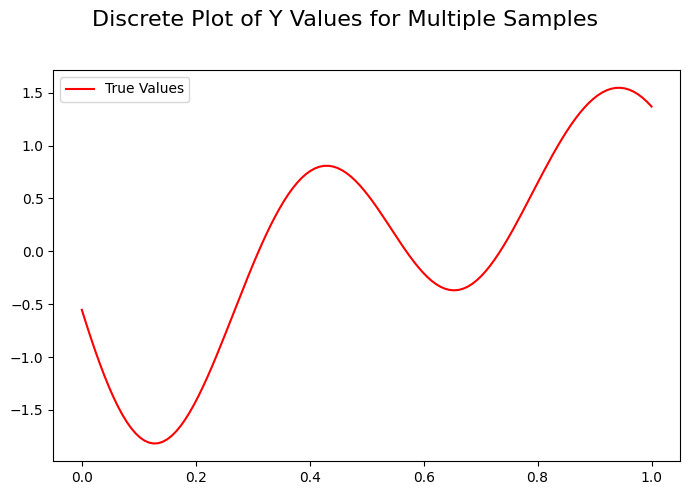

In [ ]:
import matplotlib.pyplot as plt
model.eval()
torch.save(model.state_dict(), "model.pth")


i = 28
import matplotlib.pyplot as plt

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
fig.suptitle("Discrete Plot of Y Values for Multiple Samples", fontsize=16)

# Loop through each subplot (3x3 grid)
for idx, ax in enumerate(np.array([axes]).flatten()):

    # Select the data for this subplot
    y_branch = torch.from_numpy(train_set_branch_y[i+idx].copy()).to(device).float().unsqueeze(0)
    t_branch = torch.from_numpy(train_set_branch_t[i+idx].copy()).to(device).float().unsqueeze(0)
    t_trunk = torch.from_numpy(train_set_trunk[i+idx].copy()).to(device).float().unsqueeze(0)
    branch_mask_ = torch.from_numpy(branch_mask[i+idx].copy()).to(device).float().unsqueeze(0)


    # Forward pass
    out = model(y_branch, t_branch, t_trunk, branch_mask_)
    
    # Prepare data for plotting
    y_values = samples_noisy[i+idx]
    real_values = samples[i+idx]
    truth = test_truth[i+idx]
   # print(y_values)
    interpolate = interpolate_zeros((y_branch)[0].cpu().numpy(),(t_branch)[0].cpu().numpy())

    inter_rmse = np.sqrt(((interpolate - truth)**2).mean())
    model_rmse =np.sqrt(((out.cpu().detach().numpy() - truth)**2).mean())
   # print(((out.cpu().detach().numpy() - truth)**2).mean())
    # Plot each series on the subplot
    ax.plot(np.linspace(0,1,128), y_values, color='blue', label="Noisy Samples",marker=".",linestyle="None")
    #ax.plot(np.linspace(0,1,128), out.cpu().detach().numpy(), color='green', label="Model Output")
    ax.plot(np.linspace(0,1,128), truth, color='red', label="True Values")
 #   ax.plot(range(len(y_values)), interpolate, color='orange', label="Interpolate Values")

    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_title(f" Model-RMSE: {round(model_rmse,3)}")
    #ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
plt.show()


torch.Size([1, 128, 256])
0.05047385


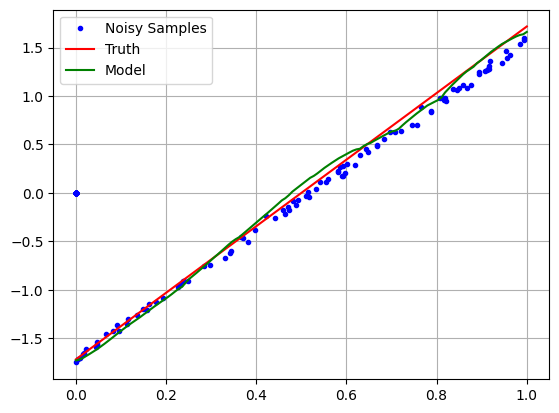

In [138]:
import matplotlib.pyplot as plt
checkpoint = torch.load('model_best.pth')
model = DeepONet(grid_size,d_model=256,heads=2,p=164)

# Restore model and optimizer state
model.load_state_dict(checkpoint)
model.to(device)

obs_grid = "0. 0.04588748 0.09159764 0.154311 0.18969745 0.23107812 0.44037433 0.46551259 0.4698422 0.47704967 0.66785167 0.81627236 0.90201521 0.95241703 1.12729778 1.14864347 1.36339895 1.49645256 1.58159458 1.61537626 1.7719714 1.92631915 2.2723072 2.30819694 2.36639828 2.39429573 2.49307768 2.83365748 2.97734284 3.30018475 3.42713179 3.44338513 3.67101318 3.70071144 3.82651719 3.96436809 4.21100116 4.4103133 4.5927691 4.6456428 4.70696965 4.73154 4.81327955 4.88203372 4.93375474 5.09674984 5.1514203 5.16924428 5.32374484 5.40409128 5.54255234 5.58893832 5.80597549 5.82208935 5.85903121 5.91029194 5.92191019 5.93088624 5.96112675 6.00609536 6.18001733 6.30389277 6.43150128 6.48084083 6.67812159 6.68206819 6.83963045 6.96922171 7.08483453 7.20008597 7.46360123 7.56433681 7.65297084 7.8679689 7.86873273 8.08294605 8.13605702 8.17417846 8.19601013 8.19857348 8.35981573 8.44979181 8.49774742 8.59409107 8.67625995 8.76494718 8.92907996 8.93134402 9.08121277 9.12686634 9.13060209 9.16862836 9.17055742 9.17844888 9.45820172 9.53187723 9.55631619 9.62251619 9.84111355 9.92931726 9.94418766".split()
obs_values = "0.85313171 0.94886456 0.9913655 1.12373941 1.1538541 1.28122004 1.32660459 1.49295406 1.42257618 1.39720176 1.73848647 1.82816094 2.04443918 1.83863094 2.07048476 2.21743274 2.36112713 2.53582418 2.50709211 2.69728738 2.75346224 2.86644065 3.2168426 3.30541183 3.40471169 3.4006658 3.41017454 3.87825226 3.90623223 4.14115363 4.2810781 4.36807786 4.80602395 4.77000786 4.64123313 5.01134075 5.4630334 5.39559734 5.65491826 5.51595296 5.72902836 5.65012075 5.92672484 5.81445033 5.94809901 6.07837817 6.21919096 6.06370414 6.31950136 6.52137031 6.52616659 6.61242782 6.87090184 6.84510611 6.99506471 6.72094563 7.039519 6.70756187 6.80345845 7.09894762 7.06580112 7.38326926 7.56279725 7.48480531 7.69555467 7.66979836 7.89036898 8.10229802 8.09277586 8.14774118 8.32538598 8.31605628 8.88322356 8.74041498 8.75358482 9.1787067 9.16509112 9.11234973 9.16522074 9.08388677 9.45401259 9.43567678 9.47647436 9.59452738 9.47847781 9.5957691 9.99459821 9.92405368 10.0093065 10.05398787 10.0765146 10.08835275 10.17442852 10.33270049 10.28733318 10.64823178 10.43109297 10.50999956 10.87251012 10.98692423 11.06202351".split()
evaluation_grid = "0. 0.07874016 0.15748031 0.23622047 0.31496063 0.39370079 0.47244094 0.5511811 0.62992126 0.70866142 0.78740157 0.86614173 0.94488189 1.02362205 1.1023622 1.18110236 1.25984252 1.33858268 1.41732283 1.49606299 1.57480315 1.65354331 1.73228346 1.81102362 1.88976378 1.96850394 2.04724409 2.12598425 2.20472441 2.28346457 2.36220472 2.44094488 2.51968504 2.5984252 2.67716535 2.75590551 2.83464567 2.91338583 2.99212598 3.07086614 3.1496063 3.22834646 3.30708661 3.38582677 3.46456693 3.54330709 3.62204724 3.7007874 3.77952756 3.85826772 3.93700787 4.01574803 4.09448819 4.17322835 4.2519685 4.33070866 4.40944882 4.48818898 4.56692913 4.64566929 4.72440945 4.80314961 4.88188976 4.96062992 5.03937008 5.11811024 5.19685039 5.27559055 5.35433071 5.43307087 5.51181102 5.59055118 5.66929134 5.7480315 5.82677165 5.90551181 5.98425197 6.06299213 6.14173228 6.22047244 6.2992126 6.37795276 6.45669291 6.53543307 6.61417323 6.69291339 6.77165354 6.8503937 6.92913386 7.00787402 7.08661417 7.16535433 7.24409449 7.32283465 7.4015748 7.48031496 7.55905512 7.63779528 7.71653543 7.79527559 7.87401575 7.95275591 8.03149606 8.11023622 8.18897638 8.26771654 8.34645669 8.42519685 8.50393701 8.58267717 8.66141732 8.74015748 8.81889764 8.8976378 8.97637795 9.05511811 9.13385827 9.21259843 9.29133858 9.37007874 9.4488189 9.52755906 9.60629921 9.68503937 9.76377953 9.84251969 9.92125984 10.".split()
evaluation_values = "1. 1.07874016 1.15748031 1.23622047 1.31496063 1.39370079 1.47244094 1.5511811 1.62992126 1.70866142 1.78740157 1.86614173 1.94488189 2.02362205 2.1023622 2.18110236 2.25984252 2.33858268 2.41732283 2.49606299 2.57480315 2.65354331 2.73228346 2.81102362 2.88976378 2.96850394 3.04724409 3.12598425 3.20472441 3.28346457 3.36220472 3.44094488 3.51968504 3.5984252 3.67716535 3.75590551 3.83464567 3.91338583 3.99212598 4.07086614 4.1496063 4.22834646 4.30708661 4.38582677 4.46456693 4.54330709 4.62204724 4.7007874 4.77952756 4.85826772 4.93700787 5.01574803 5.09448819 5.17322835 5.2519685 5.33070866 5.40944882 5.48818898 5.56692913 5.64566929 5.72440945 5.80314961 5.88188976 5.96062992 6.03937008 6.11811024 6.19685039 6.27559055 6.35433071 6.43307087 6.51181102 6.59055118 6.66929134 6.7480315 6.82677165 6.90551181 6.98425197 7.06299213 7.14173228 7.22047244 7.2992126 7.37795276 7.45669291 7.53543307 7.61417323 7.69291339 7.77165354 7.8503937 7.92913386 8.00787402 8.08661417 8.16535433 8.24409449 8.32283465 8.4015748 8.48031496 8.55905512 8.63779528 8.71653543 8.79527559 8.87401575 8.95275591 9.03149606 9.11023622 9.18897638 9.26771654 9.34645669 9.42519685 9.50393701 9.58267717 9.66141732 9.74015748 9.81889764 9.8976378 9.97637795 10.05511811 10.13385827 10.21259843 10.29133858 10.37007874 10.4488189 10.52755906 10.60629921 10.68503937 10.76377953 10.84251969 10.92125984 11.".split()
obs_grid = np.array(obs_grid, dtype=float)
obs_values = np.array(obs_values, dtype=float)
evaluation_grid = np.array(evaluation_grid, dtype=float)
evaluation_values = np.array(evaluation_values, dtype=float)

obs_values = (obs_values - obs_values.mean()) / obs_values.std() #z-scoring
evaluation_values = (evaluation_values - evaluation_values.mean()) / evaluation_values.std() #z-scoring

obs_grid = obs_grid / 10
evaluation_grid = evaluation_grid / 10


mask = np.append(np.ones(len(obs_grid)),np.zeros(len(evaluation_grid)-len(obs_grid)))
obs_grid = np.append(obs_grid,np.zeros(len(evaluation_grid)-len(obs_grid)))
obs_values = np.append(obs_values,np.zeros(len(evaluation_grid)-len(obs_values)))

mask = torch.from_numpy(mask).to(device).unsqueeze(0).float()

obs_grid = torch.from_numpy(obs_grid).to(device).unsqueeze(0).float()
obs_values = torch.from_numpy(obs_values).to(device).unsqueeze(0).float()
evaluation_grid = torch.from_numpy(evaluation_grid).to(device).unsqueeze(0).float()
evaluation_values = torch.from_numpy(evaluation_values).to(device).unsqueeze(0).float()


out = model(obs_values, obs_grid, evaluation_grid, mask)

obs_grid = obs_grid.squeeze(0).cpu().numpy()
obs_values = obs_values.squeeze(0).cpu().numpy()
evaluation_grid = evaluation_grid.squeeze(0).cpu().numpy()
evaluation_values = evaluation_values.squeeze(0).cpu().numpy()
out = out.cpu().detach().numpy()

print(np.sqrt(((out - evaluation_values)**2).mean()))

plt.plot(obs_grid, obs_values, color='blue', label="Noisy Samples",marker=".",linestyle="None")
plt.plot(evaluation_grid, evaluation_values, color='red', label="Truth")
plt.plot(evaluation_grid, out, color='green', label="Model")

plt.grid(True)
plt.legend()



#

In [77]:
import matplotlib.pyplot as plt

grid = 128
y = np.array([])
t = np.array([])
truth = np.array(grid)
x = np.linspace(0,1,grid)
mask = np.append(np.ones(len(y)),np.zeros(grid-len(y)))


y = torch.from_numpy(y).to(device).unsqueeze(0)
t = torch.from_numpy(t).to(device).unsqueeze(0)
truth = torch.from_numpy(truth).to(device).unsqueeze(0)
x = torch.from_numpy(x).to(device).unsqueeze(0)
mask = torch.from_numpy(mask).to(device).unsqueeze(0)


checkpoint = torch.load('model.pth')
model = DeepONet(grid_size,d_model=256,heads=2,p=164)

# Restore model and optimizer state
model.load_state_dict(checkpoint)
model.to(device)


out = model(y, t, x, mask)

model_rmse =np.sqrt(((out - truth)**2).mean())

plt.plot(range(len(x)), truth, color='red', label="Truth")
plt.plot(range(len(x)), out, color='green', label="Model Pred")

plt.set_xlabel("Index")
plt.set_ylabel("Y Values")
plt.set_title(f" Model-RMSE: {round(model_rmse,3)}")
plt.grid(True)
plt.legend()





RuntimeError: The size of tensor a (0) must match the size of tensor b (128) at non-singleton dimension 1